## 🧠💡 Intelligent Systems  for Smart Health 👨‍⚕👩‍⚕️🔬🌡️


# Finding hyperparameters and understanding models

In the last weeks we trained linear models, decision tree and a random forest. In all those cases we were manually adjusting hyperparameters. The more complex our models get... the more inefficient this procedure becomes. So we will look at **grid search** and **random search** as two common techniques for (still fairly simple) hyperparameter searches.

In the second part of this session we will then ask the question of how to make sense of the predictions we get from such an optimized machine learning model. Why does one patient get a good prognosis, and another one a bad one?
In this context, we will look at the **feature importance** (for a random forest model) and and **SHAP**, a newer technique to interpret model predictions.

We will (again) work with actual medical data in this notebook, namely the NHANES I epidemiology dataset (for a detailed description of this dataset you can check the [CDC Website](https://wwwn.cdc.gov/nchs/nhanes/nhefs/default.aspx/)).


<a name='import'></a>
## Import Packages

We'll first import all the common packages that we need for this assignment. 

- `shap` is a library that explains predictions made by machine learning models.
- `sklearn` is one of the most popular machine learning libraries.
- `itertools` allows us to conveniently manipulate iterable objects such as lists.
- `pydotplus` is used together with `IPython.display.Image` to visualize graph structures such as decision trees.
- `numpy` is a fundamental package for scientific computing in Python.
- `pandas` is what we'll use to manipulate our data.
- `seaborn` is a plotting library which has some convenient functions for visualizing missing data.
- `matplotlib` is a plotting library.

In [1]:
!pip install pydotplus
!pip install lifelines
!pip install shap

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24576 sha256=bcd15a33e4e9548ff709a8808377bb5536a78aa641f8edc24a9429a363000335
  Stored in directory: c:\users\sander\appdata\local\pip\cache\wheels\69\b2\67\08f0eef649af92df772c09f451558298e07fab1bc7cdf33db0
Successfully built pydotplus
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/41.2 MB ? eta -:--:--
   - -------------------------------------- 1.8/41.2 MB 16.9 MB/s eta 0:00:03
   --- ------------------------------------ 3.9/41.2 MB 5.2 MB/s eta 0:00:08
   --- ------------------------------------ 3.9/41.2 MB 5.2 MB/s eta 0:00:08
   ------- -------------------------------- 8.1/41.2 MB 5.9 MB/s eta 0:00:06
   ---------- ----------------------------- 10.7/41.2 MB 6.7 MB/s eta 0:00:05
   ------------- -------

In [67]:
import os
import shap
import sklearn
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image 

from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

<a name='1'></a>
## 1. The Dataset
### Load and explore the data!

In virtually all cases, we would first want to get an intuition on the data itself. Things like: What is in the data? How much data is there? Are there things missing? What might cause problems? Do we understand the type of data/features?

With **pandas**, we usually can explore some key properties very rapidly, for instance with commands like

- `data.head()`
- `data.describe()`
- `data.info()`

### Some weird conventions:
For some reason it became standard in the machine learning world to name the actual data `X` and the labels `y`. Even though I consider this a rather poor choice both from a math and from a code best practice point of view, we will stick to this in this notebook.

In [3]:
path_data = "../data/"

X = pd.read_csv("NHANESI_subset_X.csv")
y = pd.read_csv("NHANESI_subset_y.csv")

X = X.drop('Unnamed: 0', axis=1)
y = y.drop('Unnamed: 0', axis=1)

X.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0


In [4]:
data = X.copy()
data["time"] = y
data = data.dropna(axis="rows")
data.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,time
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0,15.274658
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0,11.586073
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0,8.149087
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0,-21.094292
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0,-0.000000


In [5]:
period = 10  # time period we consider --> we focus on >10 year risk

def died_in_period(time, period):
    # Option 1: Person died within a period
    if time > 0 and time < period:
        return 1

    # Option 2: Person left study before period ended --> no conclusion possible
    if time <= 0 and time > -period:
        return np.nan

    # Option 3 + 4: Person left study after >= period or survived >= period
    return 0
    
death_in_period = np.array([died_in_period(time, period) for time in data.time])
death_in_period

array([0., 0., 1., ..., 0., 0., 0.], shape=(8593,))

In [6]:
data["death_in_period"] = death_in_period

# Remove missing entries
data = data.dropna()

In [7]:
data.death_in_period.value_counts()

death_in_period
0.0    6954
1.0    1279
Name: count, dtype: int64

In [8]:
# Create data/label split --> X, y
X = data.drop(["death_in_period", "time"], axis='columns')
y = data["death_in_period"]

In [9]:
X.shape, y.shape

((8233, 18), (8233,))

In [10]:
X_dev, X_test, y_dev, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=10
)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X_dev, y_dev,
    test_size=0.18,
    random_state=10
)

In [12]:
X_train.shape, X_val.shape, X_test.shape

((5738, 18), (1260, 18), (1235, 18))

In [13]:
# in this context we will also use the c-index to evaluate our models
import lifelines

def cindex(y_true, scores):
    return lifelines.utils.concordance_index(y_true, scores)

<a name='2'></a>
## 2. Random Forests

As we saw last time, a single decision tree is prone to overfitting. To solve this problem, you can try **random forests**, which combine predictions from many different trees to create a robust classifier. 

As before, we will use scikit-learn to build a random forest for the data. We will use the default hyperparameters.

Using Scikit-Learn we can train such a model using the `RandomForestClassifier()` class and, again, the `fit()` method to train the model.

In [14]:
# please train a random forest model using the RandomForestClassifier() class
# start with 10 trees --> n_estimators=10
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=10, random_state=0) 

In [15]:
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=0)

### Basic first model evaluation
Here, for a start, we will simply use the C-Index. Feel free to add other measures (e.g., accuracy etc.).

In [16]:
y_train_preds = forest.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")

y_val_preds = forest.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {cindex(y_val.values, y_val_preds)}")

Train C-Index: 0.9996317058680915
Val C-Index: 0.7868259546264592


In [21]:
y_val_preds = forest.predict(X_val)
print(y_val_preds)

y_val_preds = forest.predict_proba(X_val)
print(y_val_preds)

[0. 0. 0. ... 0. 0. 0.]
[[1.  0. ]
 [0.8 0.2]
 [0.5 0.5]
 ...
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]]


In [22]:
from sklearn.metrics import accuracy_score

In [23]:
y_val_preds = forest.predict(X_val)
y_train_preds = forest.predict(X_train)

print(f"Train ACC:{accuracy_score(y_train, y_train_preds)}")
print(f"Val ACC:{accuracy_score(y_val, y_val_preds)}")

Train ACC:0.9897176716626002
Val ACC:0.8436507936507937


Training a random forest with the default hyperparameters results in a model that has better predictive performance than individual decision trees as in the previous section, but this model is overfitting.

We therefore need to tune (or optimize) the hyperparameters, to find a model that both has good predictive performance and minimizes overfitting.

The hyperparameters we choose to adjust will be:

- `n_estimators`: the number of trees used in the forest.
- `max_depth`: the maximum depth of each tree.
- `min_samples_leaf`: the minimum number (if `int`) or proportion (if `float`) of samples in a leaf.


<a name='ex1'></a>
### Exercise 1: try to find a set of better hyperparameters!


In [58]:
# train some models using different hyperparameters
forest = forest = RandomForestClassifier(n_estimators=100, max_depth=8,min_samples_leaf=0.01,random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=0.01, random_state=0)

In [59]:
y_train_preds = forest.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")

y_val_preds = forest.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {cindex(y_val.values, y_val_preds)}")

Train C-Index: 0.880932959363647
Val C-Index: 0.8448919725275825


<a name='3'></a>
## 3.Systematic search for hyperparameters: grid search

The approach we implement to tune the hyperparameters is known as a grid search:

- We define a set of possible values for each of the target hyperparameters.

- A model is trained and evaluated for every possible combination of hyperparameters.

- The best performing set of hyperparameters is returned.

The cell below implements a hyperparameter grid search, using the C-Index to evaluate each tested model.

In [63]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "max_depth": [2,5,10,20,50],
    "n_estimators": [5,10,25,80],
    "min_samples_leaf": [0.01, 0.05, 0.1]
             }

forest =RandomForestClassifier()
grid_search = GridSearchCV(forest, parameters, verbose=3)


In [64]:
# Get the best model out of the grid search with .best_params_
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END max_depth=2, min_samples_leaf=0.01, n_estimators=5;, score=0.844 total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_leaf=0.01, n_estimators=5;, score=0.844 total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_leaf=0.01, n_estimators=5;, score=0.845 total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_leaf=0.01, n_estimators=5;, score=0.845 total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_leaf=0.01, n_estimators=5;, score=0.845 total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_leaf=0.01, n_estimators=10;, score=0.844 total time=   0.1s
[CV 2/5] END max_depth=2, min_samples_leaf=0.01, n_estimators=10;, score=0.844 total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_leaf=0.01, n_estimators=10;, score=0.845 total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_leaf=0.01, n_estimators=10;, score=0.845 total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_leaf=0.01, n_estimators

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5, 10, 20, 50],
                         'min_samples_leaf': [0.01, 0.05, 0.1],
                         'n_estimators': [5, 10, 25, 80]},
             verbose=3)

In [65]:
forest = grid_search.best_estimator_

y_train_preds = forest.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")

y_val_preds = forest.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {cindex(y_val.values, y_val_preds)}")

y_test_preds = forest.predict_proba(X_test)[:, 1]
print(f"Test C-Index: {cindex(y_test.values, y_test_preds)}")

Train C-Index: 0.8715298919732237
Val C-Index: 0.8210463346749164
Test C-Index: 0.8151601759096202


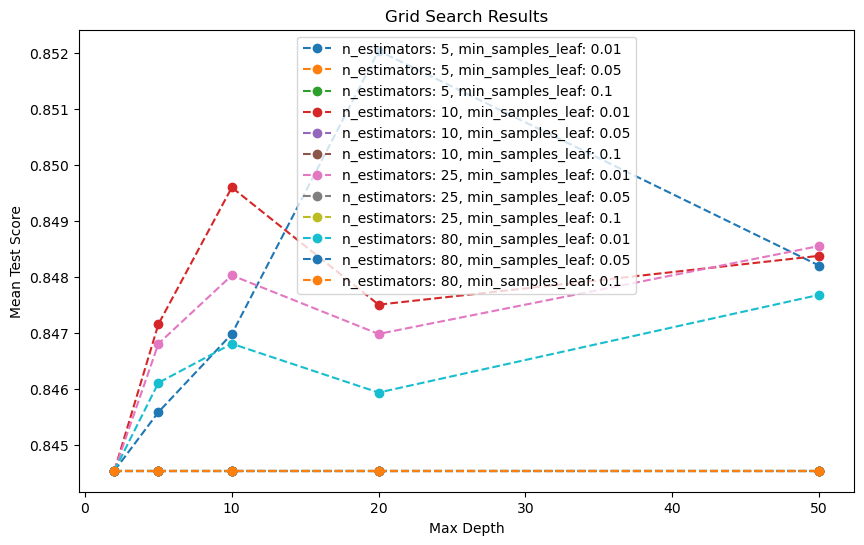

In [66]:
# Collect grid search results
cv_results = grid_search.cv_results_
mean_test_scores = cv_results['mean_test_score']
params = cv_results['params']

# Prepare data for plotting
scores_array = np.array(mean_test_scores).reshape(len(parameters['max_depth']),
                                                  len(parameters['min_samples_leaf']),
                                                  len(parameters['n_estimators']))

# Create a line plot for each n_estimators
fig, ax = plt.subplots(figsize=(10, 6))

for k, n_estimators in enumerate(parameters['n_estimators']):
    scores_for_n_estimators = scores_array[:, :, k].T
    for i, min_samples_leaf in enumerate(parameters['min_samples_leaf']):
        ax.plot(parameters['max_depth'], scores_for_n_estimators[i],
                marker='o', linestyle='--', label=f'n_estimators: {n_estimators}, min_samples_leaf: {min_samples_leaf}')

ax.set_title('Grid Search Results')
ax.set_xlabel('Max Depth')
ax.set_ylabel('Mean Test Score')
ax.legend(loc='best')

plt.show()

## Random Search
A common alternative to the simple grid search is a more randomized search. The version that is implemented in Scikit-learn is a bit of a hybrid. It can be seen as a randomized search within a grid.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {"max_depth": [],
              "min_samples_leaf": [],
              "n_estimators": []
             }

forest = RandomForestClassifier()
random_search = # add your code

In [ ]:
xlabel = "n_estimators"
ylabel = "max_depth"
zlabel = "min_samples_leaf"
x_pos = []
y_pos = []
z_pos = []
for param in random_search.cv_results_["params"]:
    x_pos.append(param[xlabel])
    y_pos.append(param[ylabel])
    z_pos.append(param[zlabel])

plt.scatter(x_pos, y_pos, s=50*np.array(z_pos),
            c=random_search.cv_results_["mean_test_score"])
plt.colorbar(label="mean test score")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xscale("log")

In [ ]:
# take the "best" model
model = # add your code

## 4. Optional (if time) Training a lightGBM model

XGBoost models became somewhat famous on platforms such as Kaggle, because they were very often found in the top ranks of the leadboards. So let's give this a try as well!

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

<a name='5'></a>
## 5. Explainability
Using a random forest has improved results, but we've lost some of the natural interpretability of trees. In this section we'll try to explain the predictions using slightly more sophisticated techniques. 

But first, we will simply look at the **feature importance**:

---
### Just to all be on the same page: let's train one last model!

In [68]:
model = RandomForestClassifier(n_estimators=100,
                               max_depth=7,
                               min_samples_leaf=5,
                               random_state=10)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=5, random_state=10)

In [ ]:
# use .feature_importances_ to get the respective values of our model

In [69]:
feature_importance = pd.DataFrame(model.feature_importances_,
                                 columns=["feature_importance"],
                                 index=X_train.columns)
feature_importance.sort_values("feature_importance", ascending=False)

,feature_importance
Age,0.337463
Pulse pressure,0.086116
Sedimentation rate,0.068386
Systolic BP,0.063699
Sex,0.060685
Poverty index,0.044895
BMI,0.043073
Serum Albumin,0.036509
White blood cells,0.035515
TIBC,0.033894


<a name='shap'></a>
## Better than only feature importance: SHAP

Looking at the feature importance was interesting, and tells us a bit more about the model.
But since recently, we can do much better!

Now we will apply **SHAP (SHapley Additive exPlanations)**, a cutting edge method that explains predictions made by black-box machine learning models (i.e. models which are too complex to be understandable by humans as is).

> Given a prediction made by a machine learning model, SHAP values explain the prediction by quantifying the additive importance of each feature to the prediction. SHAP values have their roots in cooperative game theory, where Shapley values are used to quantify the contribution of each player to the game.
> 
> Although it is computationally expensive to compute SHAP values for general black-box models, in the case of trees and forests there exists a fast polynomial-time algorithm. For more details, see the [TreeShap paper](https://arxiv.org/pdf/1802.03888.pdf).

We'll use the [shap library](https://github.com/slundberg/shap) to do this for our random forest model. Run the next cell to output the most at risk individuals in the test set according to our model.

In [70]:
proba_death = model.predict_proba(X_test)[:, 1]

In [71]:
X_test_risk = X_test.copy(deep=True)
X_test_risk["predicted_risk"] = proba_death
X_test_risk = X_test_risk.sort_values("predicted_risk", ascending=False)
X_test_risk.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,predicted_risk
5493,67.0,80.0,30.0,1.0,77.7,59.0,3.4,231.0,36.0,1.40,6.3,1.0,170.0,202.0,17.8,8.4,17.029470,90.0,0.654311
8628,73.0,70.0,71.0,2.0,40.1,60.0,3.8,187.0,58.0,1.97,7.0,2.0,130.0,220.0,26.4,10.9,16.998084,60.0,0.626556
2036,74.0,96.0,210.0,1.0,42.1,51.0,4.2,175.0,93.0,1.70,7.5,1.0,206.0,346.0,26.9,7.0,23.667245,110.0,0.623782
2469,70.0,70.0,54.0,1.0,44.5,24.0,4.3,205.0,206.0,1.78,7.9,1.0,190.0,343.0,60.1,7.7,17.595799,120.0,0.598181
7256,74.0,104.0,253.0,1.0,55.3,8.0,4.5,267.0,74.0,1.79,7.6,1.0,210.0,478.0,15.5,5.1,27.020329,106.0,0.593765


We can use SHAP values to try and understand the model output on specific individuals using force plots. Run the cell below to see a force plot on the riskiest individual. 

In [72]:
i = 100
patientID = X_test_risk.index[i]
print(patientID)
print(X_test.loc[patientID, :], "\n")
print(f"Our model predicts: {model.predict(X_test.loc[[patientID]])}")

5917
Age                    66.000000
Diastolic BP           80.000000
Poverty index         865.000000
Race                    1.000000
Red blood cells        77.700000
Sedimentation rate      3.000000
Serum Albumin           4.100000
Serum Cholesterol     215.000000
Serum Iron             78.000000
Serum Magnesium         1.940000
Serum Protein           6.600000
Sex                     1.000000
Systolic BP           120.000000
TIBC                  371.000000
TS                     21.000000
White blood cells      11.200000
BMI                    16.628761
Pulse pressure         40.000000
Name: 5917, dtype: float64 

Our model predicts: [0.]


### Why this prediction?

### Using SHAP's general "Explainer"

In [73]:
explainer = shap.TreeExplainer(model)# add your code

In [77]:
shap_values = explainer.shap_values(X_test.loc[patientID])

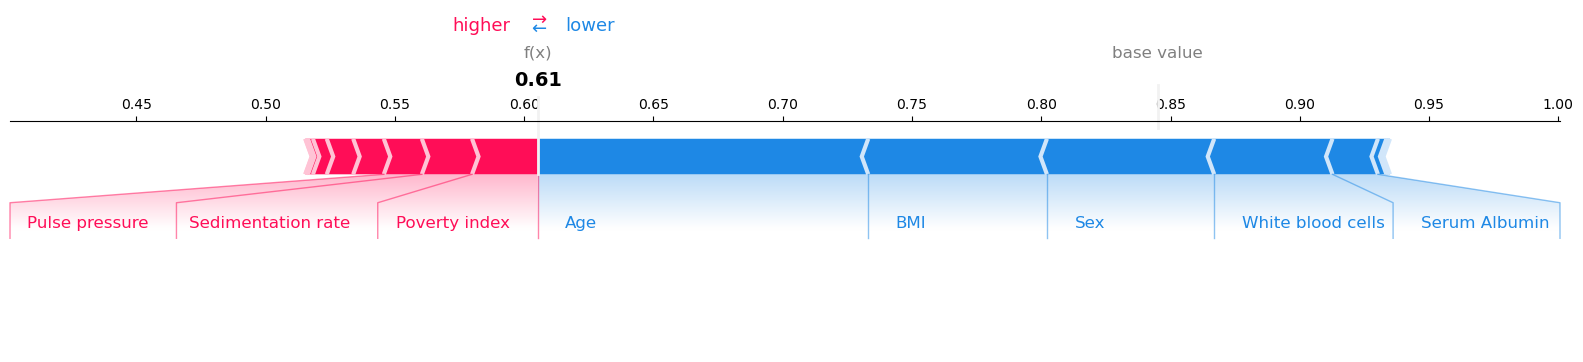

In [78]:
prediction_class = 0

shap.force_plot(
    explainer.expected_value[prediction_class], shap_values[:, prediction_class],
    feature_names=X_test.columns,
    matplotlib=True
)

### Using SHAP's "TreeExplainer"

In [ ]:
explainer = shap.TreeExplainer(model)

In [ ]:
shap_values = # add your code

In [ ]:
shap.force_plot(
    explainer.expected_value[prediction_class], shap_value,
    feature_names=X_test.columns,
    matplotlib=True
)

### Summary plot

In [80]:
explainer = shap.Explainer(model, X_train.iloc[:1000, :])
shap_values = explainer(X_train.iloc[:5, :], check_additivity=False)

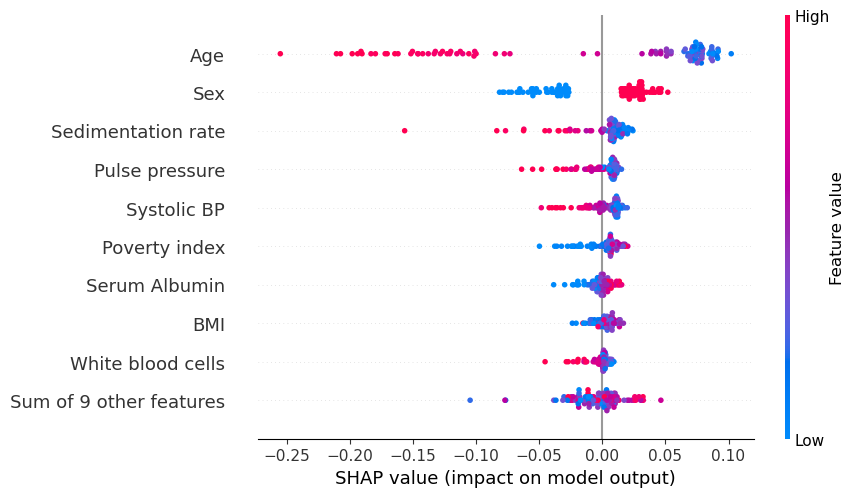

In [81]:
shap.plots.beeswarm(shap_values[:,:,0])

In [ ]:
# or

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(...)

shap.summary_plot(...)